In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports and Configurations

## 1. Import Libraries

In [1]:
import os
import cv2
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models.video import r3d_18
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## 2. Configurations

In [2]:
DATA_DIR = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"
BATCH_SIZE = 16
EPOCHS = 10
#LR = 1e-3
NUM_FRAMES = 16
IMG_SIZE = 112
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Preprocessing

## 1. Load Data

In [3]:
normal_videos = glob(os.path.join(DATA_DIR, "non shop lifters", "*.mp4"))
shoplifting_videos = glob(os.path.join(DATA_DIR, "shop lifters", "*.mp4"))

all_videos = normal_videos + shoplifting_videos
all_labels = [0] * len(normal_videos) + [1] * len(shoplifting_videos)

## 2. Split Data into Train/Validation/Test Splits

In [4]:
print(len(all_videos), len(all_labels))


855 855


In [5]:
train_videos, temp_videos, train_labels, temp_labels = train_test_split(all_videos, all_labels, test_size=0.2, shuffle=True, random_state=SEED, stratify=all_labels)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, stratify=temp_labels)

print(f'Train Samples: {len(train_videos)}')
print(f'Validation Samples: {len(val_videos)}')
print(f'Test Samples: {len(test_videos)}')

Train Samples: 684
Validation Samples: 85
Test Samples: 86


In [6]:
def print_class_distribution(labels, split_name):
    """Print class distribution and percentages"""
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    
    print(f"\n{split_name} Set:")
    print(f"Total samples: {total}")
    for label, count in zip(unique, counts):
        percentage = (count / total) * 100
        class_name = "Non-Shoplifter" if label == 0 else "Shoplifter"
        print(f"  Class {label} ({class_name}): {count} samples ({percentage:.2f}%)")

# Check distribution for all splits
print_class_distribution(train_labels, "Training")
print_class_distribution(val_labels, "Validation")
print_class_distribution(test_labels, "Test")



Training Set:
Total samples: 684
  Class 0 (Non-Shoplifter): 425 samples (62.13%)
  Class 1 (Shoplifter): 259 samples (37.87%)

Validation Set:
Total samples: 85
  Class 0 (Non-Shoplifter): 53 samples (62.35%)
  Class 1 (Shoplifter): 32 samples (37.65%)

Test Set:
Total samples: 86
  Class 0 (Non-Shoplifter): 53 samples (61.63%)
  Class 1 (Shoplifter): 33 samples (38.37%)


## 3. Define Frame Sampling Function

In [7]:
def sample_uniform_frames(video_path, num_frames=NUM_FRAMES):
    """Uniformly sample frames from a video, pad if needed."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames >= num_frames:
        frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    else:
        frame_indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            frame = frames[-1]  # fallback to last frame if broken
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return np.array(frames)

## 4. Define VideoDataset Class

In [8]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = sample_uniform_frames(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        # Shape: (T, C, H, W) for CNN-RNN architecture
        frames = torch.stack(frames)  # Remove the .permute() that was in original code
        return frames, label


## 5. Transforms

In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

## 6. Datasets and Loaders

In [10]:
train_dataset = VideoDataset(train_videos, train_labels, transform=train_transform)
val_dataset = VideoDataset(val_videos, val_labels, transform=val_test_transform)
test_dataset = VideoDataset(test_videos, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=4, pin_memory=True)


## 7. Show a Train Video's Frames Before and After Augmentation

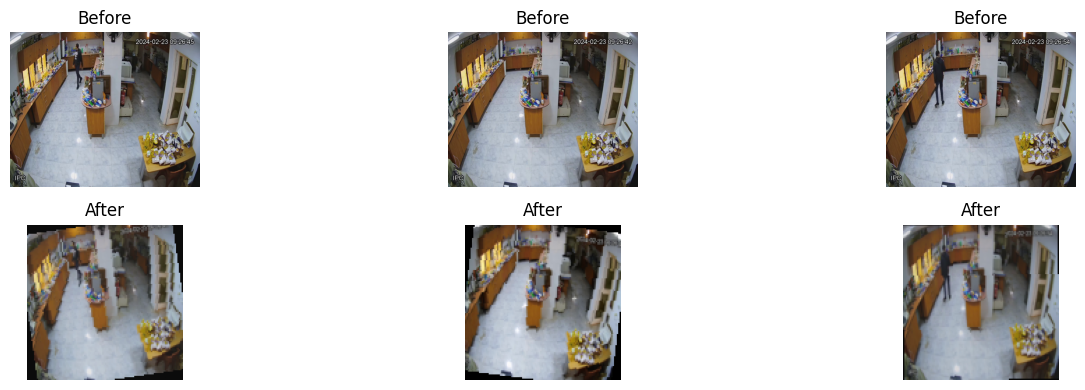

In [11]:
from PIL import Image

def show_video_frames_before_after(videos, transform, num_frames_to_show=5):
    """
    Display some frames from a video before and after augmentation.
    """
    # Randomly select a video
    video_path = random.choice(videos)

    # Sample the selected videos into frames
    frames = sample_uniform_frames(video_path)
    frames = list(frames)
    
    # Select random frames
    selected_frames = random.sample(frames, num_frames_to_show)
    
    fig, axes = plt.subplots(2, num_frames_to_show, figsize=(15, 4))
    
    for i, frame in enumerate(selected_frames):
        # Before augmentation
        axes[0, i].imshow(frame)
        axes[0, i].axis('off')
        axes[0, i].set_title("Before")
        
        # After augmentation
        aug_frame = transform(frame)
        aug_frame = aug_frame.permute(1, 2, 0)  # CHW → HWC
        axes[1, i].imshow(aug_frame)
        axes[1, i].axis('off')
        axes[1, i].set_title("After")
    
    plt.tight_layout()
    plt.show()

show_video_frames_before_after(train_videos, train_transform, num_frames_to_show=3)

## 8. Adding class weights to fix imbalance

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on training data
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights: {class_weights}")
print(f"  Non-Shoplifter (class 0): {class_weights[0]:.4f}")
print(f"  Shoplifter (class 1): {class_weights[1]:.4f}")

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)



Class weights: tensor([0.8047, 1.3205], device='cuda:0')
  Non-Shoplifter (class 0): 0.8047
  Shoplifter (class 1): 1.3205


# Modeling

## 1. Build Model

In [13]:
# Replace the hardcoded calculation with:
class CNN_RNN_Model(nn.Module):
    def __init__(self, num_classes=2, hidden_size=256, num_lstm_layers=2, dropout=0.5):
        super(CNN_RNN_Model, self).__init__()
        
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Add adaptive pooling to make it flexible
            nn.AdaptiveAvgPool2d((7, 7))
        )
        
        # Now this is guaranteed to be correct
        self.cnn_output_size = 512 * 7 * 7
        
        # RNN (LSTM) for temporal modeling
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()
        
        # Process each frame through CNN
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.cnn(x)
        
        # Flatten CNN output
        x = x.view(batch_size * num_frames, -1)
        
        # Reshape for LSTM
        x = x.view(batch_size, num_frames, -1)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use mean pooling instead of just last timestep
        x = torch.mean(lstm_out, dim=1)
        
        # Classification
        x = self.fc(x)
        
        return x


## 2. Define Traning and Evaluation Functions

In [16]:
# Initialize the model
model = CNN_RNN_Model(num_classes=2, hidden_size=256, num_lstm_layers=2, dropout=0.5)
model = model.to(device)

# Print model summary
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
LR = 1e-4  # Changed from 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate per-class accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    for class_idx in [0, 1]:
        class_mask = all_labels == class_idx
        if class_mask.sum() > 0:
            class_acc = (all_preds[class_mask] == all_labels[class_mask]).sum() / class_mask.sum()
            class_name = "Non-Shoplifter" if class_idx == 0 else "Shoplifter"
            print(f"  {class_name} accuracy: {class_acc*100:.2f}%")
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item(), all_preds, all_labels


Total parameters: 58,240,706
Trainable parameters: 58,240,706


In [17]:
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

# Check model is on GPU
print(f"Model on GPU: {next(model.parameters()).is_cuda}")


Device: cuda
CUDA available: True
Current device: 0
Device name: Tesla P100-PCIE-16GB
Model on GPU: True


## 3. Train Model

In [18]:
best_val_acc = 0.0
best_val_loss = 100.0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}")
    print(f"Val Loss: {val_loss:.4f}   | Val Accuracy: {val_acc*100:.2f}")

    if (val_acc > best_val_acc) or ((val_acc == best_val_acc) and (val_loss < best_val_loss)):
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_CNN_RNN_model.pth")
        print("✅ Saved Best Model")

Epoch 1/10


  Non-Shoplifter accuracy: 77.36%
  Shoplifter accuracy: 15.62%
Train Loss: 0.6933 | Train Accuracy: 55.26
Val Loss: 0.6932   | Val Accuracy: 54.12
✅ Saved Best Model
Epoch 2/10


  Non-Shoplifter accuracy: 0.00%
  Shoplifter accuracy: 100.00%
Train Loss: 0.6939 | Train Accuracy: 56.14
Val Loss: 0.6880   | Val Accuracy: 37.65
Epoch 3/10


  Non-Shoplifter accuracy: 100.00%
  Shoplifter accuracy: 0.00%
Train Loss: 0.6898 | Train Accuracy: 55.12
Val Loss: 0.6827   | Val Accuracy: 62.35
✅ Saved Best Model
Epoch 4/10


  Non-Shoplifter accuracy: 83.02%
  Shoplifter accuracy: 81.25%
Train Loss: 0.6774 | Train Accuracy: 62.72
Val Loss: 0.6430   | Val Accuracy: 82.35
✅ Saved Best Model
Epoch 5/10


  Non-Shoplifter accuracy: 94.34%
  Shoplifter accuracy: 59.38%
Train Loss: 0.5524 | Train Accuracy: 82.02
Val Loss: 0.5090   | Val Accuracy: 81.18
Epoch 6/10


  Non-Shoplifter accuracy: 94.34%
  Shoplifter accuracy: 78.12%
Train Loss: 0.4339 | Train Accuracy: 83.92
Val Loss: 0.4040   | Val Accuracy: 88.24
✅ Saved Best Model
Epoch 7/10


  Non-Shoplifter accuracy: 100.00%
  Shoplifter accuracy: 43.75%
Train Loss: 0.3527 | Train Accuracy: 87.57
Val Loss: 0.7039   | Val Accuracy: 78.82
Epoch 8/10


  Non-Shoplifter accuracy: 100.00%
  Shoplifter accuracy: 71.88%
Train Loss: 0.1946 | Train Accuracy: 93.71
Val Loss: 0.4404   | Val Accuracy: 89.41
✅ Saved Best Model
Epoch 9/10


  Non-Shoplifter accuracy: 100.00%
  Shoplifter accuracy: 100.00%
Train Loss: 0.2281 | Train Accuracy: 92.54
Val Loss: 0.0099   | Val Accuracy: 100.00
✅ Saved Best Model
Epoch 10/10


  Non-Shoplifter accuracy: 98.11%
  Shoplifter accuracy: 100.00%
Train Loss: 0.0517 | Train Accuracy: 98.68
Val Loss: 0.0568   | Val Accuracy: 98.82


## 4. Loss and Accuracy Plots

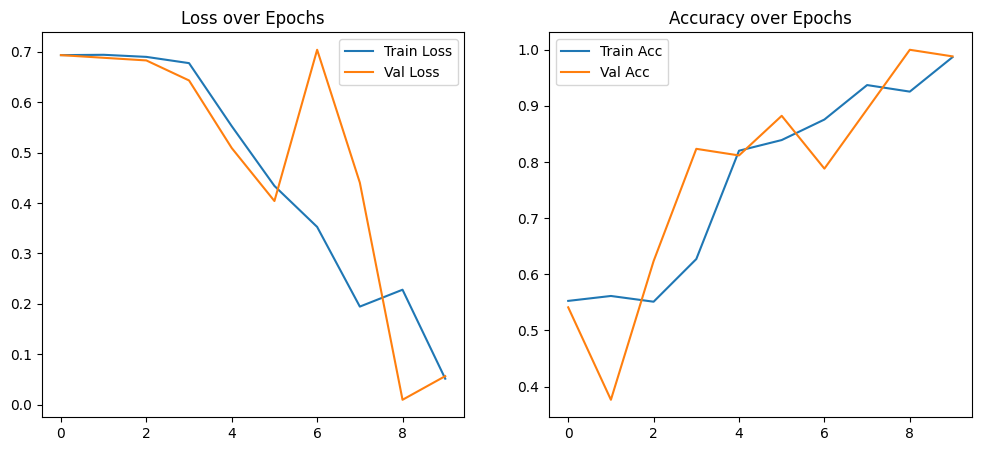

In [19]:
# Accuracy/Loss Plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1,2,2)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Evaluation

## 1. Test Model

In [20]:
model.load_state_dict(torch.load("best_CNN_RNN_model.pth"))
test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc*100:.2f}")

  Non-Shoplifter accuracy: 98.11%
  Shoplifter accuracy: 100.00%
Test Accuracy: 98.84


## 2. Confusion Matrix

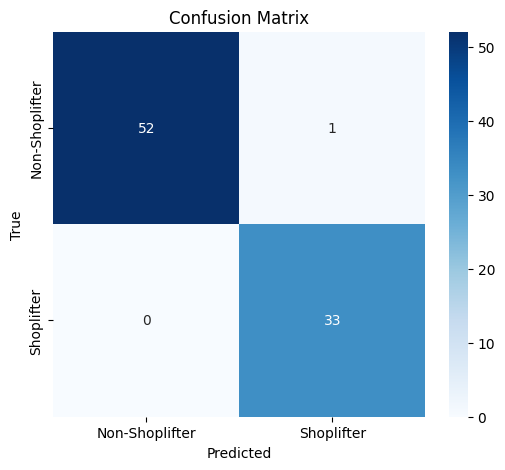

In [21]:
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Shoplifter", "Shoplifter"],
            yticklabels=["Non-Shoplifter", "Shoplifter"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 3. Download the Best Model

In [22]:
from IPython.display import FileLink

FileLink('best_CNN_RNN_model.pth')

/kaggle/working/best_CNN_RNN_model.pth